# Pipeline for mitogenomes based phylogeny
## Importing module and defining some functions

In [219]:
pwd

'/home/mshuvo/Thesis_project/Phylogeny_part/24_June/01_genes'

In [220]:
import os
import pandas as pd
from Bio import SeqIO, Seq, motifs
from Bio.SeqRecord import SeqRecord
import subprocess
import re
import pathlib
import shutil

cwd = os.getcwd()

# Functions to import fasta in a DataFrame, and write fasta from such a DataFrama

def df2fas(df, fasta, seqName="seqName", sequence="sequence", write=True):
    """
    Dump all sequences as fasta for each markers
    """
    res = '>' + df[seqName] + '\n' + df[sequence]
    res = res.to_csv(index=False, header=False).replace('"', '')
     
    if write:
        with open(fasta, 'w') as f:
            f.write(res)
        f.close()
    return res

def fas2df(fasta, marker, source='', is_extract_tagged=False):
    """
    From a fasta file create a DataFrame [extractId, sequence] 
    Uses Biopython to parse the fasta
    """
    recGen = SeqIO.parse(fasta, "fasta")
    recId, recSeq = zip(*[(x.id , str(x.seq)) for x in recGen])
    #x.seq = class Bio.Seq.Seq, attribute str get the sequence string
    df = pd.DataFrame.from_dict(dict([('seqName', recId), ('sequence', recSeq)]))
    df['marker'] = marker
    if is_extract_tagged:
        df["extract"] = df["seqName"].str.split('__').str[1]
        df["extractSeqId"] = 1
        df["comments"] = None
        df['rawChromat'] = None
        df['cdhSeqName'] = df['seqName']
        df['id'] = None
        df['accession'] = None
    df['source'] = source
    return df

## User parameters: working directories path and name of the outgroup MOTU

In [179]:
#Conventions are:
#rDNA fasta must be named such as : rDNA.fasta
#PCG nucleotide sequences must be named such as : XXX.fasta
#PCG aminoacid sequences will be automatically created from above and will be named such as : XXX.AA.fasta


# working_directory, contain the lib_taxa.tsv file and subdir as follow:
work_dir = '/home/mshuvo/Thesis_project/Phylogeny_part/24_June'
#gene_dir contains all the non-aligned sequences fasta
gene_dir = f'{work_dir}/01_genes'
filtered_gene_dir = f'{work_dir}/02_genes_filtered_taxa'

#align_out_dir receive all the aligned sequences fasta
align_out_dir = f'{work_dir}/03_alignments'
#tree_dir receive the iqtree2 analyses and subanalyses
tree_dir = f'{work_dir}/04_trees'

outgroup = 'NC_005938__Speleonectes_tulumensis'

gene_dir content should be like this:

    12SrDNA.fasta  atp6.fasta  cob.fasta   cox2.fasta  nad1.fasta  nad3.fasta  nad4l.fasta  nad6.fasta
    16SrDNA.fasta  atp8.fasta  cox1.fasta  cox3.fasta  nad2.fasta  nad4.fasta  nad5.fasta

## Loading the dataset and the lib_taxa file

## Optional: remove OTUs from the initial dataset. If no OTU to remove, provide an empty list

In [180]:
to_exclude = ['P2_261', 'P4_14', 'P2_16', 'a_66', 'a3_12', 'MI_487', 'P2_251', 'P4_21', 'a67', 'P1_28']

with open (gene_dir + '/OTUs_to_exclude.txt', 'w') as txt:
    txt.write("\n".join(to_exclude))
    
for f in os.listdir(gene_dir): 
    if '.fasta' in f:
        cmd = f"/opt/seqkit/seqkit grep -v -f {gene_dir}/OTUs_to_exclude.txt -o {filtered_gene_dir}/{f} {gene_dir}/{f}".split(' ')
        subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


In [181]:
# Loading lib_tax into a DataFrame
lib_taxa = pd.read_csv(f'{work_dir}/lib_taxa.tsv', sep="\t", header=None)
lib_taxa.columns = ['seqName', 'batch', 'countgroup', 'phylum', 'taxon', 'taxid']

# Listing the non-aligned fasta files
fasta_rDNA = [f"{filtered_gene_dir}/{f}" for f in os.listdir(filtered_gene_dir) if 'rDNA.fasta' in f]
fasta_PCG = [f"{filtered_gene_dir}/{f}" for f in os.listdir(filtered_gene_dir) if (not 'AA.fasta' in f) and (not 'rDNA.fasta' in f) and ('.fasta' in f)]

# Translating the PCG and creating AA.fasta files
translate = lambda x: str(Seq.Seq(x).translate(table = 5)).replace('*','')

for fasta in fasta_rDNA:
    df = fas2df(fasta, 'osef')
    df['seqName'] = df['seqName'].str.replace(r'(.+)_-_.*', r'\1')
    df2fas(df, fasta)
    
for fasta in fasta_PCG:
    df = fas2df(fasta, 'osef')
    df['seqName'] = df['seqName'].str.replace(r'(.+)_-_.*', r'\1')
    df2fas(df, fasta)
    df['sequence'] = df['sequence'].apply(translate)
    df2fas(df, fasta.replace('.fasta', '.AA.fasta'))

# Listing the AA.fasta files:
fasta_PCG_AA = [f"{filtered_gene_dir}/{f}" for f in os.listdir(filtered_gene_dir) if ('AA.fasta' in f)]

/opt/anaconda3/lib/python3.8/site-packages/Bio/Seq.py:2855: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


## Aligning the rDNA and AA using mafft most accurate strategy, AA alignements are backtranslated in nuc alignements using Trimal; then use Trimal again to remove ambigous sites and gap-only sites

In [182]:
for fasta in (fasta_PCG_AA + fasta_rDNA):
    print(f'Aligning {os.path.basename(fasta)}')
    out = f'{align_out_dir}/{os.path.basename(fasta)}ln'
    cmd = f'mafft --localpair --maxiterate 1000 {fasta}'.split(' ')
    with open(out, 'wb') as f:
        res = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        f.write(res.stdout)

for fastaln in [f"{align_out_dir}/{f}" for f in os.listdir(align_out_dir) if 'AA.fastaln' in f]:
    nucfas=f'{filtered_gene_dir}/{os.path.basename(fastaln)[:-2].replace("AA.", "")}'
    cmd2=f'/opt/trimai/trimal -in {fastaln} -out {fastaln.replace("AA.", "")} -backtrans {nucfas} -ignorestopcodon'.split(" ")
    subprocess.run(cmd2, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    
for fastaln in [f"{align_out_dir}/{f}" for f in os.listdir(align_out_dir) if 'SrDNA.fastaln' in f]:
    cmd3=f'/opt/trimai/trimal -in {fastaln} -out {fastaln.replace(".fastaln", ".trimmed.fastaln")}'.split(" ")
    subprocess.run(cmd3, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

Aligning atp8.AA.fasta
Aligning atp6.AA.fasta
Aligning cox2.AA.fasta
Aligning cob.AA.fasta
Aligning cox1.AA.fasta
Aligning cox3.AA.fasta
Aligning nad1.AA.fasta
Aligning nad3.AA.fasta
Aligning nad2.AA.fasta
Aligning nad4l.AA.fasta
Aligning nad4.AA.fasta
Aligning nad6.AA.fasta
Aligning nad5.AA.fasta
Aligning 16SrDNA.fasta
Aligning 12SrDNA.fasta


## Rename all the sequences using the lib_taxa information (libid + taxon name), write those fasta in the "tree" directory, create the nucleotid supermatrix of rDNA + all PCG (nucleotides), named all_nuc.fastaln

In [183]:
fastaln_sets = [f"{align_out_dir}/{f}" for f in os.listdir(align_out_dir) if not ('rDNA.fastaln' in f) and ('.fastaln' in f)]
print(fastaln_sets)
concat_df = pd.DataFrame()
for fasta in fastaln_sets:
    source=''
    if ('AA.fasta' in fasta):
        source='.AA' 
    #if ('trimmed.fasta' in fasta):
    #    source='.trimmed' 
    gene_name = re.sub(r"(\w+)\..+", r"\1", os.path.basename(fasta))
    df = fas2df(fasta, gene_name, source=source)
    df.columns = ['seqName', gene_name, "marker", "source"]
    df = df.merge(lib_taxa[['seqName', 'taxon']], how='left', on='seqName')
    df['seqName'] = df['seqName'] + "__" + df['taxon'].str.replace(' ', '_')
    df2fas(df[['seqName', gene_name]], f'{tree_dir}/{gene_name}{source}.fastaln', sequence=gene_name);
    #print(df.seqName.iloc[0])
    df = df.set_index('seqName')
    if source != '.AA' :
        concat_df = pd.concat([concat_df, df.iloc[:,0:1]], axis=1)
for gene in concat_df.columns:
    fillingna = 'n' * int(concat_df[gene].str.len().max())
    concat_df[gene] = concat_df[gene].fillna(fillingna)
concat_df['full_NUC'] = concat_df.sum(axis=1)
concat_df.index.name = "seqName"
concat_df = concat_df.reset_index()
df2fas(concat_df[['seqName', 'full_NUC']], f'{tree_dir}/all_nuc.fastaln', sequence='full_NUC');

['/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/atp8.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/atp6.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/cox2.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/cob.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/cox1.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/cox3.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad1.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad3.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad2.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad4l.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad4.AA.fastaln', '/home/mshuvo/Thesis_project/Phylogeny_part/24_June/03_alignments/nad6.AA.f

## Creates the gene partition table for the supermatrix, raxml style

In [184]:
partitions = concat_df.T.iloc[1:-1,0:1]
partitions.columns=['length']
partitions['length'] = partitions['length'].str.len()
partitions['last'] = partitions['length'].cumsum()
partitions['first'] = partitions['last'].shift(1)
partitions['first'] = (partitions['first'].fillna(0) + 1).astype('int')
partitions['line'] = "DNA, " + partitions.index + '_c1' + " = " + partitions['first'].astype('str') + '-' + partitions['last'].astype('str')
partitions['line_c2'] = "DNA, " + partitions.index + '_c2' + " = " + (partitions['first'] + 1).astype('str') + '-' + partitions['last'].astype('str')
partitions['line_c3'] = "DNA, " + partitions.index + '_c3' + " = " + (partitions['first'] + 2 ).astype('str') + '-' + partitions['last'].astype('str')


partitions['line'] = partitions['line'].where(partitions['line'].str.contains('rDNA'), 
                                              partitions['line'] + '\\3\n' + partitions['line_c2'] + '\\3\n' + partitions['line_c3'] + '\\3'
                                             )


partition_table = partitions[['line']].to_csv(sep='\t', header=None, index=False).replace('"','')
partition_file = f'{tree_dir}/all_nuc.partitions'
with open(partition_file, 'w') as f:
    f.write(partition_table)
    
    
print("Printing missing data for each genes (total number of missing bases)")
missing_data = concat_df.copy()

for col in concat_df.columns[1:]:
    missing_data[col] = concat_df[col].str.count('(n|N|\?)')
    
missing_data.to_csv('./missing_data.tsv', sep='\t')

Printing missing data for each genes (total number of missing bases)


## Run all the phylogenetic analyses and sub analyses

In [185]:
fastaln_sets = [f"{tree_dir}/{f}" for f in os.listdir(tree_dir) if ('.fastaln' in f) and (not 'all_nuc.fastaln' in f)]

for fasta in fastaln_sets:
    gene_name = re.sub(r"(.+)\..+", r"\1", os.path.basename(fasta))
    print(f'Starting iqtree2 inference for {gene_name}')
    try:
        shutil.rmtree(f'{tree_dir}/{gene_name}')
    except:
        pass
    pathlib.Path(f'{tree_dir}/{gene_name}').mkdir(parents=True, exist_ok=True)
    shutil.copyfile(fasta, f'{tree_dir}/{gene_name}/{os.path.basename(fasta)}')
    cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/{gene_name}/{os.path.basename(fasta)} -T 1 -B 5000 -o {outgroup}'.split(' ')
    print(f'Running {" ".join(cmd)}')
    subprocess.Popen(cmd)
    
# Running analyses on the supermatrix:
# Without partitionning
try:
    shutil.rmtree(f'{tree_dir}/all_nuc')
except:
    print('error')
    pass
pathlib.Path(f'{tree_dir}/all_nuc').mkdir(parents=True, exist_ok=True)
shutil.copyfile(f'{tree_dir}/all_nuc.fastaln', f'{tree_dir}/all_nuc/all_nuc.fastaln')
cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/all_nuc/all_nuc.fastaln --ancestral  -T 1 -B 5000 -o {outgroup}'.split(' ')
print(f'Running {" ".join(cmd)}')
subprocess.Popen(cmd)

# With partitionning, single model
try:
    shutil.rmtree(f'{tree_dir}/all_nuc_partition')
except:
    print('error')
    pass
pathlib.Path(f'{tree_dir}/all_nuc_partition').mkdir(parents=True, exist_ok=True)
shutil.copyfile(f'{tree_dir}/all_nuc.fastaln', f'{tree_dir}/all_nuc_partition/all_nuc.fastaln')
shutil.copyfile(f'{partition_file}', f'{tree_dir}/all_nuc_partition/all_nuc.partitions')


cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/all_nuc_partition/all_nuc.fastaln --prefix all_nuc_partition --ancestral  -T 4 -B 5000 -alrt 1000 -o {outgroup} -p {tree_dir}/all_nuc_partition/all_nuc.partitions'.split(' ')
print(f'Running {" ".join(cmd)}')

os.chdir(f'{tree_dir}/all_nuc_partition')
subprocess.Popen(cmd)
os.chdir(cwd)

# With partitionning, auto model selection for each partition
try:
    shutil.rmtree(f'{tree_dir}/all_nuc_automodel')
except:
    print('error')
    pass
pathlib.Path(f'{tree_dir}/all_nuc_automodel').mkdir(parents=True, exist_ok=True)
shutil.copyfile(f'{tree_dir}/all_nuc.fastaln', f'{tree_dir}/all_nuc_automodel/all_nuc.fastaln')
shutil.copyfile(f'{partition_file}', f'{tree_dir}/all_nuc_automodel/all_nuc.partitions')
cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/all_nuc_automodel/all_nuc.fastaln --prefix all_nuc_automodel --ancestral  -T 4 -B 5000 -alrt 1000 -o {outgroup} -p {tree_dir}/all_nuc_automodel/all_nuc.partitions -m MFP+MERGE'.split(' ')
print(f'Running {" ".join(cmd)}')

os.chdir(f'{tree_dir}/all_nuc_automodel')
subprocess.Popen(cmd)
os.chdir(cwd)

Starting iqtree2 inference for atp8.AA
Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/atp8.AA/atp8.AA.fastaln -T 1 -B 5000 -o NC_005938__Speleonectes_tulumensis
Starting iqtree2 inference for atp6.AA
Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/atp6.AA/atp6.AA.fastaln -T 1 -B 5000 -o NC_005938__Speleonectes_tulumensis
Starting iqtree2 inference for cox2.AA
Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/cox2.AA/cox2.AA.fastaln -T 1 -B 5000 -o NC_005938__Speleonectes_tulumensis
Starting iqtree2 inference for cob.AA
Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/cob.AA/cob.AA.fastaln -T 1 -B 5000 -o NC_005938__Speleonectes_tulumensis
Starting iqtree2 inference for cox1.AA
Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/cox1.AA/cox1.AA.fastaln -T 1 -B 5000 -o NC_00593

In [186]:
try:
    shutil.rmtree(f'{tree_dir}/all_nuc_partition')
except:
    print('error')
    pass
pathlib.Path(f'{tree_dir}/all_nuc_partition').mkdir(parents=True, exist_ok=True)
shutil.copyfile(f'{tree_dir}/all_nuc.fastaln', f'{tree_dir}/all_nuc_partition/all_nuc.fastaln')
shutil.copyfile(f'{partition_file}', f'{tree_dir}/all_nuc_partition/all_nuc.partitions')


cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/all_nuc_partition/all_nuc.fastaln --prefix all_nuc_partition --ancestral -T 4 -B 5000 -alrt 1000 -o {outgroup} -p {tree_dir}/all_nuc_partition/all_nuc.partitions'.split(' ')
print(f'Running {" ".join(cmd)}')

os.chdir(f'{tree_dir}/all_nuc_partition')
subprocess.Popen(cmd)
os.chdir(cwd)

Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/all_nuc_partition/all_nuc.fastaln --prefix all_nuc_partition --ancestral -T 4 -B 5000 -alrt 1000 -o NC_005938__Speleonectes_tulumensis -p /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/all_nuc_partition/all_nuc.partitions


In [187]:
try:
    shutil.rmtree(f'{tree_dir}/all_nuc')
except:
    print('error')
    pass
pathlib.Path(f'{tree_dir}/all_nuc').mkdir(parents=True, exist_ok=True)
shutil.copyfile(f'{tree_dir}/all_nuc.fastaln', f'{tree_dir}/all_nuc/all_nuc.fastaln')
shutil.copyfile(f'{partition_file}', f'{tree_dir}/all_nuc/all_nuc')


cmd = f'/opt/iqtree2/iqtree2 -s {tree_dir}/all_nuc/all_nuc.fastaln --prefix all_nuc --ancestral -T 4 -B 5000 -alrt 1000 -o {outgroup} -p {tree_dir}/all_nuc/all_nuc'.split(' ')
print(f'Running {" ".join(cmd)}')

os.chdir(f'{tree_dir}/all_nuc')
subprocess.Popen(cmd)
os.chdir(cwd)

Running /opt/iqtree2/iqtree2 -s /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/all_nuc/all_nuc.fastaln --prefix all_nuc --ancestral -T 4 -B 5000 -alrt 1000 -o NC_005938__Speleonectes_tulumensis -p /home/mshuvo/Thesis_project/Phylogeny_part/24_June/04_trees/all_nuc/all_nuc


# Plot GC content

In [221]:
cd /home/mshuvo/Thesis_project/Phylogeny_part/24_June/01_genes

/home/mshuvo/Thesis_project/Phylogeny_part/24_June/01_genes


In [283]:
all_files=os.listdir()
names=set()
gc={}

for each_file in all_files:
    if each_file=='.ipynb_checkpoints' or each_file=='shahin.tsv':
        continue
    
    gc[each_file.split('.')[0]+'_GC_perc']={}
        
    total_text=''
    with open(each_file,'r') as f:
        total_text = f.read()
    text_list=total_text.split(">")
    valid_list=text_list[1:]
    
    
    # Start looping

    for each_item in valid_list:
        coll=each_item.split("\n")
        names.add(coll[0])
        gc_perc=((coll[1].count('g')+coll[1].count('G'))+(coll[1].count('c')+coll[1].count('C'))) / len(coll[1]) * 100
        gc[each_file.split('.')[0]+'_GC_perc'][coll[0]]=gc_perc


d = {'SeqID': list(names)}
for key in gc:
    
    temporary_list=[]
    for each_item in df['SeqID']:
        try:
            temporary_list.append(gc[key][each_item])
        except KeyError:
            temporary_list.append('NA')
    d[key] = temporary_list 
       
df = pd.DataFrame(data=d)
df.to_csv("GC_genes.tsv", sep = '\t', index=False)


In [293]:
df = pd.read_csv('~/Thesis_project/Phylogeny_part/24_June/order_family_species.tsv', sep='\t')
df = df.set_index(['Libid', 'Order'])

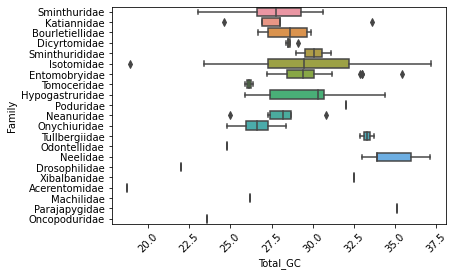

<Figure size 432x288 with 0 Axes>

In [294]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.boxplot(x='Total_GC', y='Family', data = df[['Total_GC', 'Family']])
plt.xticks(rotation=45)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('totalgcVSfamily.png', dpi=100, bbox_inches='tight')

In [295]:
df = pd.DataFrame(df.iloc[:,4:].stack()).reset_index()

In [296]:
df.columns = ['libid', 'order', 'gene', 'gc_perc']

In [297]:
df

,libid,order,gene,gc_perc
0,P4_22,SYMPHYPLEONA,cox1_GC_perc,31.68
1,P4_22,SYMPHYPLEONA,cox3_GC_perc,29.02
2,P4_22,SYMPHYPLEONA,nad3_GC_perc,23.15
3,P4_22,SYMPHYPLEONA,nad1_GC_perc,23.90
4,P4_22,SYMPHYPLEONA,nad2_GC_perc,21.02
...,...,...,...,...
1823,NC_044134,Symphypleona,nad4l_GC_perc,26.67
1824,NC_044134,Symphypleona,nad4_GC_perc,29.51
1825,NC_044134,Symphypleona,atp8_GC_perc,27.78
1826,NC_044134,Symphypleona,atp6_GC_perc,29.07


In [298]:
import matplotlib.pyplot as plt

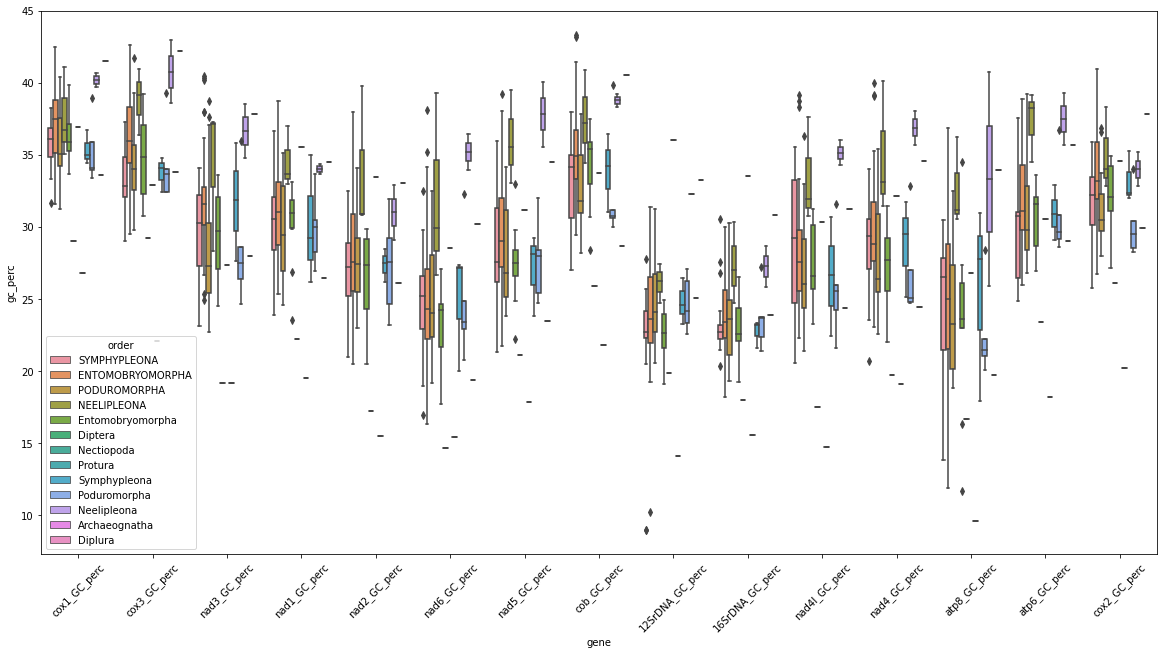

In [299]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.boxplot(y='gc_perc', x='gene', hue='order', data = df, ax=ax)
#sns.swarmplot(y='gc_perc', x='gene', hue='order', data = df, ax=ax)
plt.xticks(rotation=45)
plt.savefig('gcVSgene.png')

In [302]:
df = pd.read_csv('~/Thesis_project/Phylogeny_part/24_June/order_family_species.tsv', sep='\t')

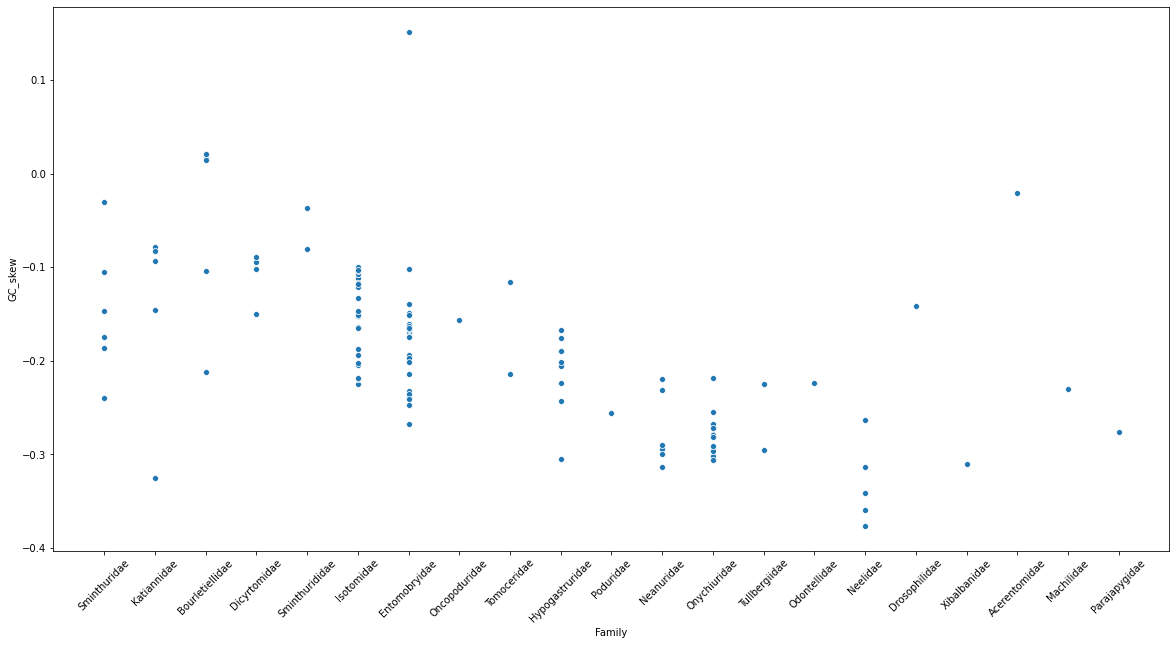

In [309]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.scatterplot(y='GC_skew', x='Family', data = df, ax=ax)
#sns.swarmplot(y='gc_perc', x='gene', hue='order', data = df, ax=ax)
plt.xticks(rotation=45)
plt.savefig('gc_skewVSgene.png')

In [116]:
#GC_skew & AT_skew

In [176]:
total_text=''
with open('./count_all_nuc.fasta','r') as f:
    total_text = f.read()
text_list=total_text.split(">")

valid_list=text_list[1:]

# Start looping
names=[]
values=[]
a=[]
t=[]
g=[]
c=[]
at_skew=[]
gc_skew=[]
gc=[]
at=[]

for each_item in valid_list:
    coll=each_item.split("\n")
    names.append(coll[0])
    values.append(coll[1])
    
    a_perc=(coll[1].count('a')+coll[1].count('A')) / len(coll[1]) * 100
    a.append(a_perc)
    t_perc=(coll[1].count('t')+coll[1].count('T')) / len(coll[1]) * 100
    t.append(t_perc)
    g_perc=(coll[1].count('g')+coll[1].count('G')) / len(coll[1]) * 100
    g.append(g_perc)
    c_perc=(coll[1].count('c')+coll[1].count('C')) / len(coll[1]) * 100
    c.append(c_perc)
    at_skew.append((a_perc-t_perc)/float(a_perc+t_perc))
    gc_skew.append((g_perc-c_perc)/float(g_perc+c_perc))
    gc_perc=((coll[1].count('g')+coll[1].count('G'))+(coll[1].count('c')+coll[1].count('C'))) / len(coll[1]) * 100
    gc.append(gc_perc)
    at_perc=((coll[1].count('a')+coll[1].count('A'))+(coll[1].count('t')+coll[1].count('T'))) / len(coll[1]) * 100
    at.append(at_perc)

    
d = {'Libid': names, 'A%':a, 'T%':t, 'G%':g, 'C%':c, 'GC%':gc, 'AT%':at, 'AT_skew':at_skew , 'GC_skew': gc_skew}
df = pd.DataFrame(data=d)
pd.options.display.float_format = '{:.2f}'.format
#df.round(2)
df.to_csv('count.tsv', sep = '\t', index=False)
